### Resumo do Capítulo 5: The Discrete Fourier Transform

O capítulo aborda a **Transformada Discreta de Fourier (DFT)** como uma solução computacionalmente viável para análise de sinais, superando limitações de transformadas anteriores (DTFT e z-transform). Principais tópicos:

1. **Introdução à DFT**:
   - Motivação: DTFT e z-transform são não computáveis numericamente devido a somas infinitas e variáveis contínuas.
   - DFT é obtida pela amostragem da DTFT no círculo unitário.

2. **Série de Fourier Discreta (DFS)**:
   - Definição para sequências periódicas.
   - Relação com z-transform: DFS corresponde a amostras da z-transform no círculo unitário.

3. **Amostragem e Reconstrução**:
   - Efeitos de aliasing no domínio do tempo.
   - Fórmulas de reconstrução da DTFT a partir de amostras.

4. **Propriedades da DFT**:
   - Simetria circular, deslocamento circular, convolução circular e Parseval.
   - Implementação eficiente via matriz DFT.

5. **Convolução com DFT**:
   - Implementação de convolução linear via convolução circular (com zero-padding).
   - Métodos de blocagem: Overlap-Save e Overlap-Add.

6. **FFT (Fast Fourier Transform)**:
   - Algoritmos radix-2 (decimation-in-time e decimation-in-frequency).
   - Complexidade: $ O(N \log N) $ vs. $ O(N^2) $ da DFT direta.
   - Aplicações em convolução rápida.

7. **Implementação Prática**:
   - Uso de FFT para eficiência computacional.
   - Trade-off entre resolução e densidade espectral.

---


#### 1. Exemplo 5.1: Cálculo da DFS

In [18]:
import numpy as np

def dfs(xn, N):
    n = np.arange(N)
    k = np.arange(N).reshape(-1, 1)  # Transforma em coluna
    W = np.exp(-1j * 2 * np.pi / N)  # Fator de rotação
    Wnk = W ** (n * k)               # Matriz de rotação N x N
    Xk = xn @ Wnk                    # Produto interno
    return Xk

# Exemplo 5.1: Sequência periódica: [0, 1, 2, 3] com período N=4.
xn = np.array([0, 1, 2, 3])
N = 4
Xk = dfs(xn, N)

print("Coeficientes DFS:", np.round(Xk, 2))

Coeficientes DFS: [ 6.+0.j -2.+2.j -2.-0.j -2.-2.j]


#### 2. Exemplo 5.6: DFT vs. DTFT

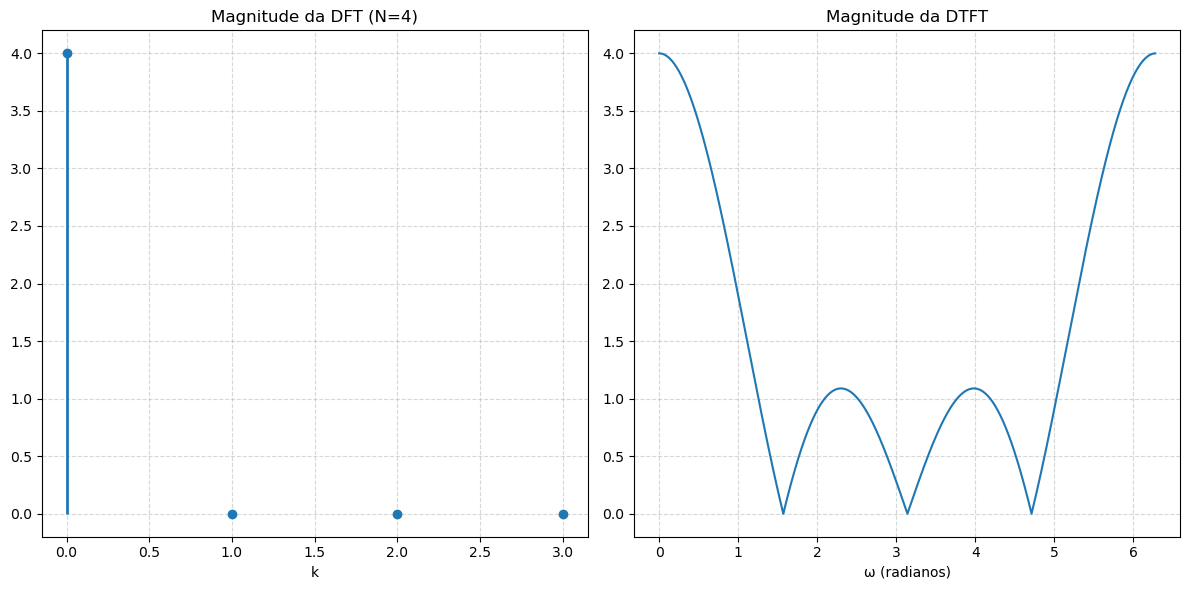

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def dtft(xn, omega):
    """
    Calcula a DTFT de uma sequência em frequências omega.
    
    Parâmetros:
        xn : array_like
            Sinal de entrada.
        omega : array_like
            Frequências angulares.
    
    Retorna:
        X : ndarray
            DTFT calculada nas frequências omega.
    """
    n = np.arange(len(xn))
    return np.sum(xn * np.exp(-1j * omega[:, None] * n), axis=1)

# Sequência x(n) = [1, 1, 1, 1]
xn = np.ones(4)
N = len(xn)

# DFT usando FFT
Xk_dft = np.fft.fft(xn)

# DTFT 
omega = np.linspace(0, 2*np.pi, 1000, endpoint=False)
X_dtft = dtft(xn, omega)

plt.figure(figsize=(12, 6))

# Magnitude da DFT 
plt.subplot(121)
k = np.arange(N)
markerline, stemlines, baseline = plt.stem(k, np.abs(Xk_dft), basefmt=' ')
plt.setp(stemlines, 'linewidth', 2)
plt.setp(markerline, 'markersize', 6)
plt.title("Magnitude da DFT (N=4)")
plt.xlabel("k")
plt.grid(True, linestyle='dashed', alpha=0.5)

# Magnitude da DTFT
plt.subplot(122)
plt.plot(omega, np.abs(X_dtft))
plt.title("Magnitude da DTFT")
plt.xlabel("ω (radianos)")
plt.grid(True, linestyle='dashed', alpha=0.5)

plt.tight_layout()
plt.show()

#### 3. Exemplo 5.13: Convolução Circular

In [26]:
def circonvt(x1, x2, N):
    """
    Convolução circular de duas sequências usando DFT.
    
    Parâmetros:
        x1, x2 : array_like
            Sequências de entrada.
        N : int
            Comprimento da convolução circular.
    
    Retorna:
        y : ndarray
            Resultado da convolução circular.
    """
    return np.real(np.fft.ifft(np.fft.fft(x1, N) * np.fft.fft(x2, N)))

# Exemplo 5.13: 
x1 = np.array([1, 2, 2])
x2 = np.array([1, 2, 3, 4])
N = 4
y = circonvt(x1, x2, N)

print("Convolução circular (N=4):", y)

Convolução circular (N=4): [15. 12.  9. 14.]


#### 4. Exemplo 5.18: Overlap-Save


In [29]:

def ovrlpsav(x, h, N):
    """
    Implementa o método Overlap-Save para convolução de blocos.
    
    Parâmetros:
        x : array_like
            Sinal de entrada.
        h : array_like
            Resposta ao impulso (deve ter comprimento menor que N).
        N : int
            Comprimento do bloco (deve ser maior que len(h)).
    
    Retorna:
        y : ndarray
            Sinal de saída (convolução linear).
    """
    M = len(h)
    M1 = M - 1
    L = N - M1   # Número de novas amostras por bloco
    # Adiciona zeros no início e no final
    x = np.pad(x, (M1, M1), 'constant', constant_values=(0, 0))
    # Número de blocos
    K = (len(x) - M1) // L
    y = np.zeros(K * L)  # Inicializa o vetor de saída
    for k in range(K):
        # Segmento de entrada (comprimento N)
        xk = x[k*L : k*L + N]
        # Convolução circular
        yk = circonvt(xk, h, N)
        # Salva as amostras válidas (descartando as primeiras M-1 amostras)
        y[k*L : (k+1)*L] = yk[M1:]
    return y

# Exemplo 5.18: 
n = np.arange(10)
x = n + 1  # x(n) = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
h = np.array([1, 0, -1])  # h(n) = [1, 0, -1]
N = 6  # Comprimento do bloco
y = ovrlpsav(x, h, N)

print("Resultado do Overlap-Save:", y)

Resultado do Overlap-Save: [  1.   2.   2.   2.   2.   2.   2.   2.   2.   2.  -9. -10.]


#### 5. Exemplo 5.20: FFT de 4 pontos


In [36]:

def fft4(x):
    """
    Implementa o algoritmo FFT de 4 pontos.
    
    Parâmetros:
        x : array_like
            Sequência de entrada de 4 pontos.
    
    Retorna:
        Xk : ndarray
            DFT de 4 pontos.
    """
    # Etapa 1: Butterfly
    g1 = x[0] + x[2]
    g2 = x[1] + x[3]
    h1 = x[0] - x[2]
    h2 = x[1] - x[3]
    # Etapa 2
    X0 = g1 + g2
    X1 = h1 - 1j * h2
    X2 = g1 - g2
    X3 = h1 + 1j * h2
    return np.array([X0, X1, X2, X3])

# Exemplo: 
xn = np.array([0, 1, 2, 3])
Xk = fft4(xn)
print("FFT de 4 pontos:", np.round(Xk, 2))

FFT de 4 pontos: [ 6.+0.j -2.+2.j -2.+0.j -2.-2.j]


# 🎥 Vídeos sobre DFT e Transformada de Fourier

## Vídeo 1 – Transformada de Fourier para sinais discretos (UNIVESP)
https://youtu.be/acyRz-zGzC0?si=EW_j9E2svIrDU8XI

## Vídeo 2 – Processamento Digital de Sinais - Convolução Circular (UNIVESP)
https://youtu.be/B6jR6hqn4K8?si=oxpxJlUcR363vGAb

## Vídeo 3 – FFT – Transformada Rápida de Fourier (UNIVESP)
https://youtu.be/2DwDZjAS_Zc?si=AGgriU4UDd3xLVu-


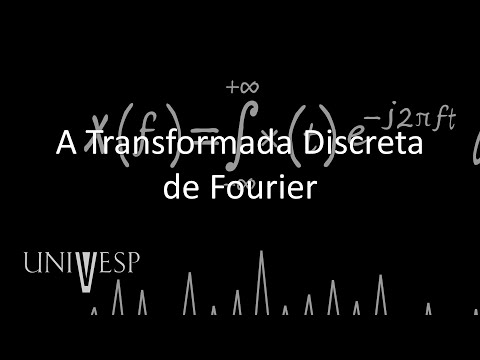

In [41]:
from IPython.display import YouTubeVideo

# Vídeo 1 – Transformada de Fourier para sinais discretos (UNIVESP)
YouTubeVideo('acyRz-zGzC0', width=800, height=450)


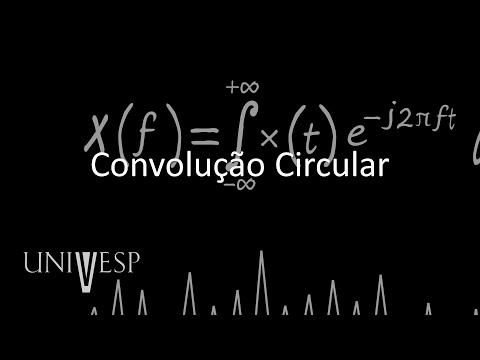

In [43]:
# Vídeo 2 – Processamento Digital de Sinais - Convolução Circular (UNIVESP)
YouTubeVideo('B6jR6hqn4K8', width=800, height=450)


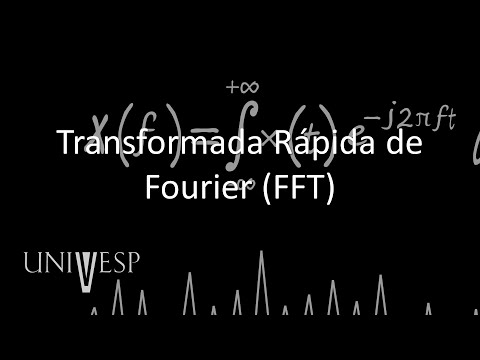

In [45]:
# Vídeo 3 – FFT – Transformada Rápida de Fourier (UNIVESP)
YouTubeVideo('2DwDZjAS_Zc', width=800, height=450)
